# Medical Image Segmentation: Registration

Please first check if simple itk packages is installed (https://simpleitk.org/). In this assignment, you will be asked to test image registration onf lung field images

Note that you are ALLOWED to use functions from scipy, matplotlib, simple itk, and numpy Python packages.

# Database

The function below shows how to open and visualize a lung X-ray using simple itk. Please be sure that you correctly specified the path to the data for this assignment.

In [2]:
import numpy as np
import numpy.linalg as npla
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rc("image", cmap = "gray")

from math import ceil
def imshow_many(imgs,
                titles   = [],
                figsize   = (16, 8),
                fig_title = None,
                do_show  = True,
                png_out  = None):
    n = len(imgs)

    x, y = (2, 2) if n == 4 else (ceil(n / 3), min(n, 3))
    fig, axes = plt.subplots(x, y, figsize = figsize)
    axes_flat = axes.ravel() if n > 1 else [axes]
    
    m = len(axes_flat)
    imgs   += [None] * (m - n)
    titles += [None] * (m - len(titles))

    for ax, (img, title) in zip(axes_flat, zip(imgs, titles)):
        if img is None:
            ax.axis("off")
        else:
            ax.imshow(img)
            if title is not None:
                ax.set_title(title)

    if fig_title is not None:
        fig.suptitle(fig_title)

    fig.tight_layout()

    if do_show:
        plt.show()
    if png_out is not None:
        fig.savefig(png_out, bbox_inches = "tight")

    return fig, axes_flat


def normalize_01(img):
    img = img.astype(float)
    _min = img.min()
    return (img - _min) / (img.max() - _min)

def normalize(img):
    return (img - img.mean()) / img.std()

def dice(img, mask):
    # TP: guessed object; was object.
    # FP: guessed object; was background.
    # FN: guessed background; was object.
    # TN: guessed background; was background.
    TP = np.sum((img == 1) & (mask == 1))
    FP = np.sum((img == 1) & (mask == 0))
    FN = np.sum((img == 0) & (mask == 1))
    return 2 * TP / (2 * TP + FP + FN)

def mse(a, b):
    return np.mean((a - b) ** 2)


# Exercise 1

Please use simple itk to implement 2D image registration. Here is the example of how to do that https://simpleitk.readthedocs.io/en/v1.1.0/Examples/ImageRegistrationMethod1/Documentation.html. Check also this link https://simpleitk.org/SPIE2019_COURSE/04_basic_registration.html

Note that your function should return two objects: a) transformed image and b) transformation field

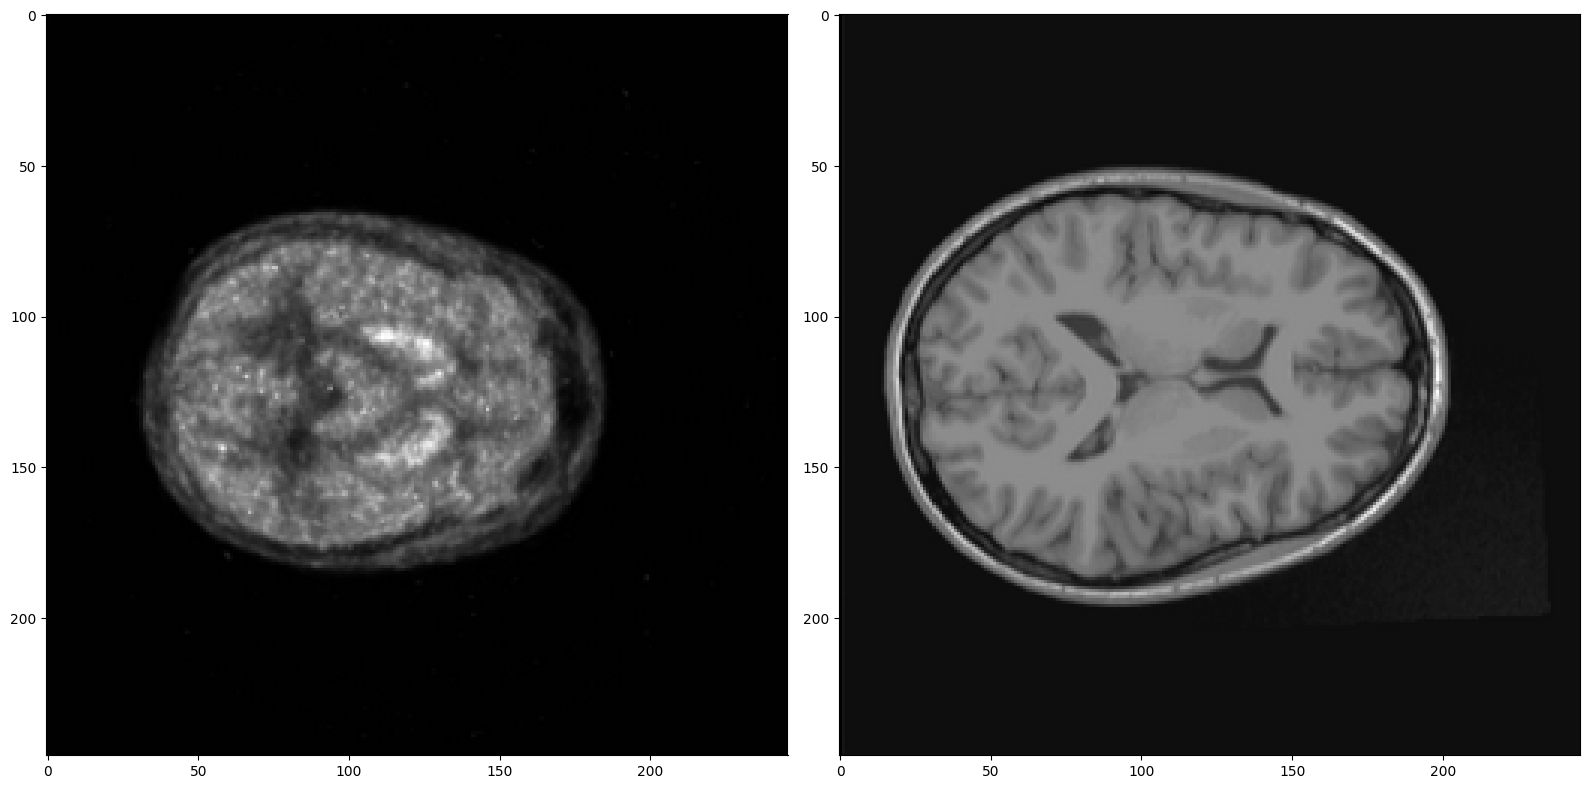

In [7]:
import SimpleITK as sitk

folder = "code/scratch/"
#  img1 = sitk.ReadImage(folder + "images/JPCLN003.bmp", sitk.sitkFloat32)
#  img2 = sitk.ReadImage(folder + "images/JPCLN009.bmp", sitk.sitkFloat32)
img2 = sitk.ReadImage("anatomical.png", sitk.sitkFloat32)
img1 = sitk.ReadImage("pet.png", sitk.sitkFloat32)

fig, axes = imshow_many([sitk.GetArrayFromImage(img1), sitk.GetArrayFromImage(img2)])


In [14]:
def set_non_rigid_transform(R, img_fixed):
    # this function should be called instead of R.SetInitialTransform
    n, m = img_fixed.GetSize()
    mesh_size = [n // 20, m // 20]
    initial_transform = sitk.BSplineTransformInitializer(
        image1 = img_fixed, transformDomainMeshSize = mesh_size, order = 2)

    transformDomainMeshSize = [2] * img_fixed.GetDimension()
    # print(transformDomainMeshSize)
    tx = sitk.BSplineTransformInitializer(img_fixed,
                                          transformDomainMeshSize )
    R.SetInitialTransformAsBSpline(initial_transform,
                                   inPlace = True,
                                   scaleFactors=[1,2,5])


def callback_iter(R):
    i = R.GetOptimizerIteration()
    if i % 20 == 0:
        print(f"iter {i}: {R.GetMetricValue()}")

# this function should use moving image img_moving to compute the transformation matrix outTx 
# that will align img_moving with img_fixed
def registration(img_moving, img_fixed, lr = 4.0, min_step = 0.05, num_iter = 500):

    R = sitk.ImageRegistrationMethod()

    # use mean squares and gradient descent.
    R.SetMetricAsMattesMutualInformation()
    R.SetOptimizerAsRegularStepGradientDescent(learningRate = lr,
                                               minStep      = min_step,
                                               numberOfIterations = num_iter)
    
    set_non_rigid_transform(R, img_fixed)
    R.SetInterpolator(sitk.sitkBSpline)
    R.AddCommand(sitk.sitkIterationEvent, lambda: callback_iter(R))
    outTx = R.Execute(img_fixed, img_moving)
    print(f"Optimizer stop condition: {R.GetOptimizerStopConditionDescription()}")
    print(f"Final metric value: {R.GetMetricValue()}")
    return outTx # this is transformation between images


# this function applies transformation to img_moving using transformation outTx
# img_fixed is needed to know the output size
#  def transform_image(img_to_transform, img_fixed, outTx):
def transform_image(img_moving, img_fixed, outTx):
    resampler = sitk.ResampleImageFilter()
    resampler.SetReferenceImage(img_fixed)
    resampler.SetInterpolator(sitk.sitkBSpline)
    #resampler.SetDefaultPixelValue(100)
    resampler.SetTransform(outTx)
    out = resampler.Execute(img_moving)
    return sitk.GetArrayFromImage(out) # this is the deformed img_to_transforms

In [15]:
print("running registration ...")
outTx = registration(img1, img2, lr = 64, min_step = 0.04)

running registration ...
iter 0: -0.4248349522762565
iter 20: -0.6778022352826286
iter 40: -0.6915953078283065
iter 60: -0.6996077239383705
iter 80: -0.7061907484654503
iter 100: -0.7103440356826625
iter 120: -0.7121639674095015
iter 140: -0.7138503405649775
iter 160: -0.7151056557020691
iter 180: -0.7162739052821103
iter 200: -0.7173805994417267
iter 220: -0.7188625741322365
iter 240: -0.7208406144524077
iter 260: -0.7228705251917171
iter 280: -0.7243460288500554
iter 300: -0.7254290070471737
iter 320: -0.7265574328382426
iter 340: -0.7272062539908976
iter 360: -0.7275410472097487
iter 380: -0.7278919932084527
iter 400: -0.728380742815757
iter 420: -0.7287875686007026
iter 440: -0.7290803810531185
iter 460: -0.7293726455530162
iter 480: -0.7296835912106049
Optimizer stop condition: RegularStepGradientDescentOptimizerv4: Maximum number of iterations (500) exceeded.
Final metric value: -0.7298419448240417


In [25]:
def get_grid(n_y, grid_size = (256, 256)):
    n_x = grid_size[1] // (grid_size[0] / n_y)
    steps_y = np.int64(np.arange(n_y) * (grid_size[0] / n_y))
    steps_x = np.int64(np.arange(n_x) * (grid_size[1] / n_x))

    xs = np.zeros(grid_size, dtype = np.uint8)
    xs[steps_y, :] = xs[:, steps_x] = 255
    return ~xs


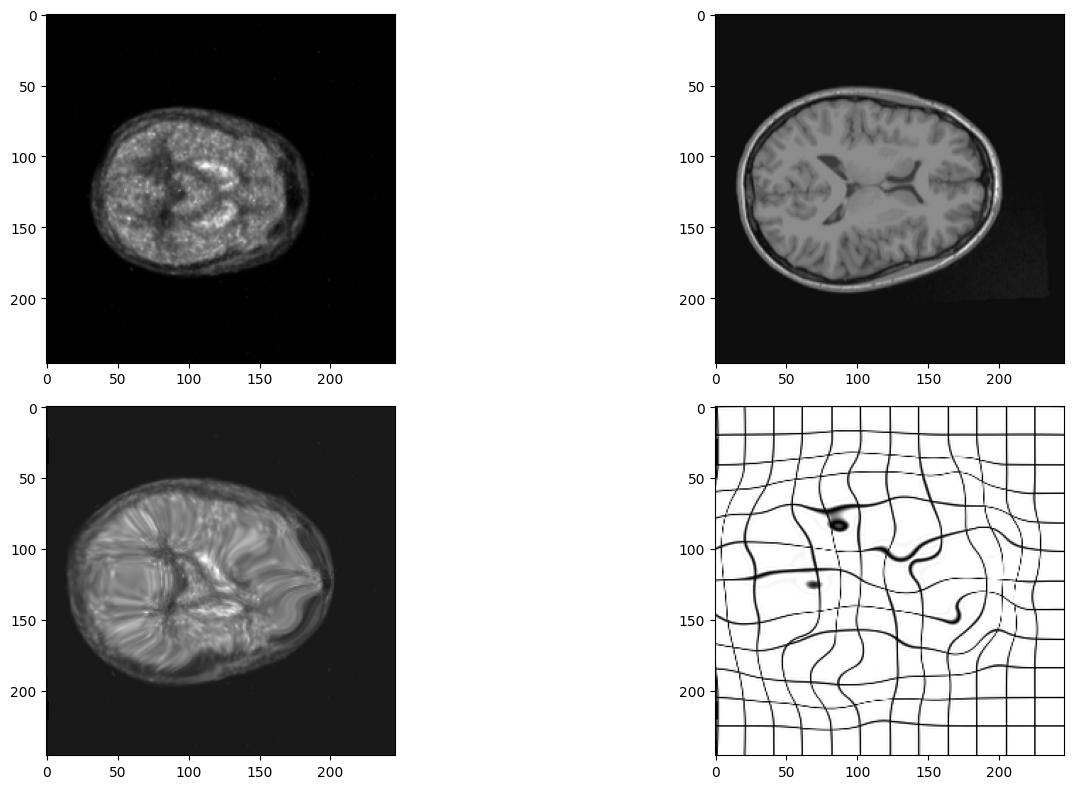

In [26]:

img2_transformed = transform_image(img1, img2, outTx)

_img1 = sitk.GetArrayFromImage(img1)
_img2 = sitk.GetArrayFromImage(img2)

grid = get_grid(12, grid_size = _img2.shape)

grid_transformed = transform_image(sitk.GetImageFromArray(grid), img1, outTx)

_fig, _axes = imshow_many([_img1, _img2, img2_transformed, grid_transformed])

In [17]:
_fig.savefig("foo_yay.png")

In [28]:
_axes[0].set_title("PET image")
_axes[1].set_title("MRI image")
_axes[2].set_title("PET -> MRI registration")
_axes[3].set_title("Deformation field")
_fig.tight_layout()
_fig.savefig("tex/figures/petmri_overfitting.png")
#_fig, _axes = imshow_many([_img1, _img2, img2_transformed + grid_transformed // 8])

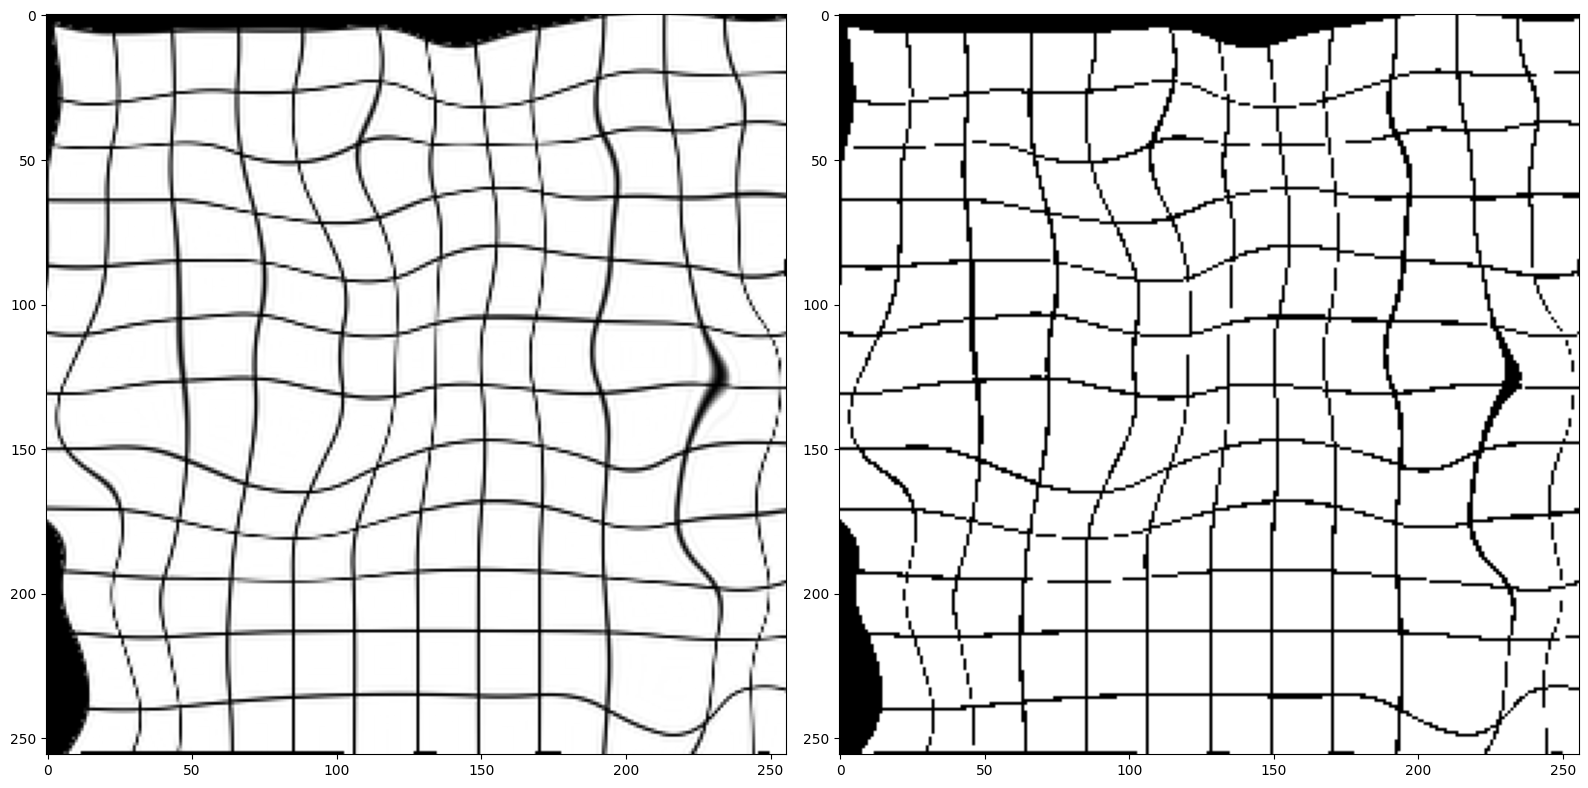

(<Figure size 1600x800 with 2 Axes>,
 array([<AxesSubplot: >, <AxesSubplot: >], dtype=object))

In [139]:

imshow_many([grid_transformed, grid_transformed_])

# Exercise 2

In this exercise you will try atlas-based segmentation of a lung field image. Please use the following code to read the training and testing images with the masks

In [10]:
train_ns = np.random.permutation(np.arange(3, 94, 2))
train_img_names = [str(n).zfill(3) for n in train_ns[:5]]
test_img_name   = str(train_ns[5]).zfill(3)

train_img_files  = [f"images/JPCLN{s}.bmp" for s in train_img_names]
train_mask_files = [f"left lung/JPCLN{s}.bmp" for s in train_img_names]

train_imgs  = [sitk.ReadImage(folder + file, sitk.sitkFloat32) for file in train_img_files]
train_masks = [sitk.ReadImage(folder + file, sitk.sitkFloat32) for file in train_mask_files]

test_img  = sitk.ReadImage(f"{folder}images/JPCLN{test_img_name}.bmp", sitk.sitkFloat32)
test_mask = sitk.ReadImage(f"{folder}left lung/JPCLN{test_img_name}.bmp", sitk.sitkFloat32)

In [14]:
# this function runs an atlas-based segmneation of lung fields
def atlas_registration(test_img, train_imgs, train_masks, lr = 24.0, min_step = 0.08, num_iter = 200):
    return np.mean([transform_image(train_mask, test_mask,
                                    registration(train_img,
                                                 test_img,
                                                 lr = lr,
                                                 min_step = min_step,
                                                 num_iter = num_iter))
                    for (train_mask, train_img) in zip(train_masks, train_imgs)
                   ], axis = 0)

atlas_result_np = atlas_registration(test_img, train_imgs, train_masks)

iter 0: 4622.256927490234
iter 20: 1135.2752902480534
iter 40: 1034.636954152097
iter 60: 934.5088013009567
iter 80: 862.4991144542635
iter 100: 809.2492993332773
iter 120: 787.4667964029228
iter 140: 765.2671675293133
iter 160: 751.0047345734673
iter 180: 739.4581808703635
Optimizer stop condition: RegularStepGradientDescentOptimizerv4: Maximum number of iterations (200) exceeded.
Final metric value: 725.2933597199896
iter 0: 2414.973175048828
iter 20: 1173.631275274726
iter 40: 1040.073742453988
iter 60: 975.0760742927329
iter 80: 928.2858099860326
iter 100: 903.2933892428314
iter 120: 880.1485879028972
iter 140: 858.6450686155367
iter 160: 838.2973073358661
iter 180: 819.8637585939384
Optimizer stop condition: RegularStepGradientDescentOptimizerv4: Maximum number of iterations (200) exceeded.
Final metric value: 797.2754453574572
iter 0: 3822.3999938964844
iter 20: 1624.8490662624865
iter 40: 1353.7819207210957
iter 60: 1239.0296734557974
iter 80: 1164.1464961198794
iter 100: 1114.6

Use code from previous exerices to compute the Dice coefficient between the reference mask 'test_mask' and the result of atlas-based segmentation 'atlas_result'.

DICE: 0.9170049134800257


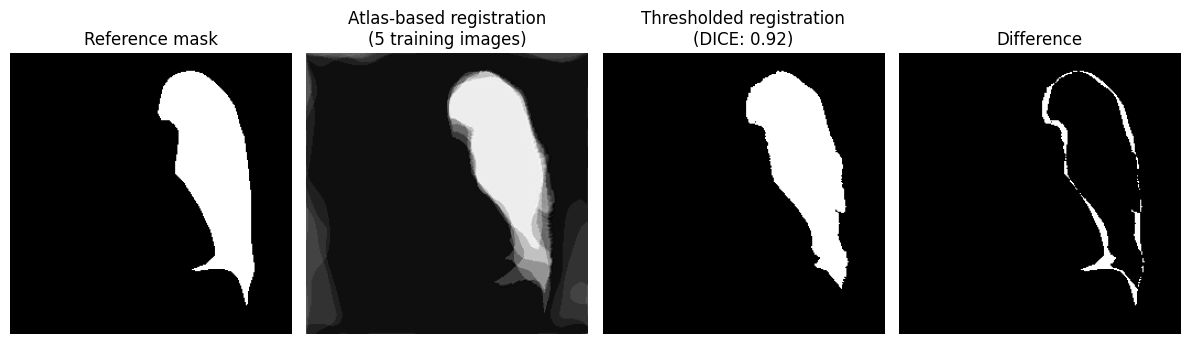

In [20]:
test_mask_np = normalize_01(sitk.GetArrayFromImage(test_mask))

th = 0.5
atlas_result_np_th = normalize_01((atlas_result_np / np.max(atlas_result_np)) > th)
dice_score = dice(test_mask_np, atlas_result_np_th) 
print(f"DICE: {dice_score}")

fig, axes = plt.subplots(1, 4, figsize = (12, 8))
ax1, ax2, ax3, ax4 = axes

ax1.imshow(test_mask_np)
ax2.imshow(atlas_result_np)
ax3.imshow(atlas_result_np_th)
ax4.imshow(normalize_01(np.abs(normalize_01(test_mask_np) - normalize_01(atlas_result_np_th))))

ax1.set_title("Reference mask")
ax2.set_title(f"Atlas-based registration\n({len(train_imgs)} training images)")
ax3.set_title(f"Thresholded registration\n(DICE: {dice_score.round(2)})")
ax4.set_title("Difference")

for ax in axes:
    ax.axis("off")
fig.tight_layout()
fig.patch.set_facecolor("white")

fig.savefig(f"atlas_registration_{len(train_imgs)}_trainimgs.png", bbox_inches = "tight")